# Email Analysis and Classification for SPAM Detection

**Project Description**

A company specialized in Artificial Intelligence–based automation, aims to develop a software library for analyzing and classifying incoming emails.  
The main objective is to identify **SPAM emails** in order to perform in-depth content analysis and improve the security of corporate communications.

The project originates from the CEO’s need to better understand **trends, content, and behaviors** associated with SPAM emails. These insights will be used to:
- enhance anti-spam filters;
- strengthen communication security;
- support strategic decisions in the cybersecurity domain.

---

**Project Objectives**

Based on an email dataset provided by the CTO, the project aims to:

- Train a **classifier** to identify SPAM emails.
- Identify the **main topics** among emails classified as SPAM.
- Compute the **semantic distance between topics** to evaluate the heterogeneity of SPAM content.
- Extract information about **organizations mentioned** in **NON-SPAM** emails.


**Dataset**

👉 https://github.com/ProfAI/natural-language-processing/tree/main/datasets/Verifica%20Finale%20-%20Spam%20Detection


## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from wordcloud import WordCloud
from scipy.spatial.distance import cosine
from collections import Counter, defaultdict
from itertools import combinations
import networkx as nx               # network graph
import time
import joblib


import re

# nlp imports
import spacy
from spacy.lang.en import English
from pprint import pprint
from gensim.models import Word2Vec
from gensim import corpora, models

# models 
from sklearn.cluster import KMeans
from sklearn.calibration import LinearSVC, CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


'\nfrom tqdm import tqdm\nimport joblib\nimport random\n\n# nlp import\nimport gensim\nfrom gensim.utils import simple_preprocess\nfrom bertopic import BERTopic\n\nimport spacy\nimport spacy.displacy as displacy\n\n\n\n# models \nfrom sklearn.cluster import KMeans\n\n\nfrom sklearn.compose import ColumnTransformer\n\n\n'

In [135]:
# Environmnt variables
!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 8.4 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 7.5 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 7.6 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 7.7 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 7.7 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 7.6 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 7.7 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Functions

In [136]:
def normalize_unicode(text):
    return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def replace_urls_emails(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return url_pattern.sub(r'url', text)

def remove_headers_tag(text):
    header_pattern = re.compile(r'^(From|To|Subject|Cc|Bcc|Date): ', re.MULTILINE)
    return header_pattern.sub('', text)

def clean_spacing(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\n+', ' ', text)  
    return text.strip() 

def base_clean(text):
    text = normalize_unicode(text)
    text = remove_html(text)
    text = replace_urls_emails(text)
    text = remove_headers_tag(text)
    text = clean_spacing(text)
    return text

In [137]:
def clean_email_metadata(text):
    text = re.sub(r'\b\w+\s*/\s*\w+\s*/\s*\w+.*', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [138]:
def tokenize_text(text):
    doc = nlp(text)
    return doc

In [139]:
def filter_tokens (doc):
    tokens = [
        token.lemma_.lower()    # lemmatization and lowercasing
        for token in doc
        if not token.is_punct   # removing punctuation
        and not token.is_stop   # removing stopwords
        and token.is_alpha      # removing non-alphabetic tokens
        and 3 <= len(token) <= 15  # choose from the boxplot
        ]
    return tokens

In [140]:
def topic_embedding(words, w2v_model):
    # Compute the mean vector for a list of words and a given Word2Vec model
    vectors = [w2v_model.wv[w[0]] for w in words if w[0] in w2v_model.wv]
    return np.mean(vectors, axis=0)

In [141]:
def get_word_cloud(words, weights, title):
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=30
    ).generate_from_frequencies(weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [142]:
def clean_orgs(orgs):
    cleaned = []
    for org in orgs:
        org_low = org.lower().strip()
        if len(org_low) < 3:
            continue
        if "/" in org_low or "@" in org_low:
            continue
        
        org_norm = ORG_NORMALIZATION.get(org_low, org)
        if org_norm in EXCLUDED_ORGS:
            continue
        cleaned.append(org_norm)
    return list(set(cleaned))

In [143]:
def extract_clean_orgs(doc):
    
    raw_orgs = [
        ent.text for ent in doc.ents
        if ent.label_ == "ORG"
    ]
    
    return clean_orgs(raw_orgs)

In [144]:
def search_organizations(str_search, org_freq, org_to_contexts):
    '''
    Search for organizations containing the given string and print their contexts
    The serach is case-sensitive
    The search is performed in the dataset frequencies and
    in the dict contexts extracted from the emails
    '''    
    print("--- Search Results ---")
    display(org_freq[org_freq['ORG'].str.contains(str_search, na=False)])


    for org, contexts in org_to_contexts.items():
        if str_search in org:
            print(f"ORG: {org}")
            for context in contexts:
                print(f"- {context}\n")

    return "--- End of Search Results ---"

In [145]:
def get_context_or_organizations(org_list, org_to_contexts, print_output=False):
    total_context = []
    for org in org_list:
        if print_output:
            print(f"ORG: {org}")
        contexts = org_to_contexts.get(org, [])
        for context in contexts:
            if print_output:
                print(f"- {context}\n")
            total_context.append(context)
    
    return total_context

In [ ]:
def make_pipeline(name, model, preprocessor, scaler, vectorizer, random_seed=0):
    '''
    Return a pipeline based on the input received
    '''
    steps = []
    steps.append(('preprocessor', preprocessor))
    steps.append(('vectorizer', vectorizer))
    steps.append(('scaler', scaler))
    steps.append((name, model))
    return Pipeline(steps=steps)

In [ ]:
def get_performance_metrics(y_test, y_pred, y_proba, name_model, label=1, conf=False):
    '''
    Return a dict with the metrics of the ML model
    '''
    
    result = {
        'Model': name_model,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=label),
        'Recall': recall_score(y_test, y_pred, pos_label=label),
        'F1 Score': f1_score(y_test, y_pred, pos_label=label),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
        }
    if conf:
        class_names = ['ham', 'spam']
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    return result

In [ ]:
def evaluate_model(name, pipeline, X, y, cv, scoring):
    results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    summary = {
        'Model': name,
        'Accuracy Mean': results['test_accuracy'].mean(),
        'Accuracy Std': results['test_accuracy'].std(),
        'F1 Mean': results['test_f1'].mean(),
        'F1 Std': results['test_f1'].std(),
        'ROC AUC Mean': results['test_roc_auc'].mean(),
        'ROC AUC Std': results['test_roc_auc'].std(),
        'Fit Time Mean (s)': results['fit_time'].mean(),
        'Fit Time Std (s)': results['fit_time'].std(),
        'Score Time Mean (s)': results['score_time'].mean(),
        'Score Time Std (s)': results['score_time'].std()
    }
    return summary

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        nlp,
        output="tokens",
        min_len=3,
        max_len=15
    ):
        """
        output:
            'tokens' → List[List[str]] (Word2Vec)
            'string' → List[str] (TF-IDF)
        """
        self.nlp = nlp
        self.output = output
        self.min_len = min_len
        self.max_len = max_len

    def fit(self, X, y=None):
        return self

    # ---------- base cleaning ----------
    def base_clean(self, text):
        text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r"http\S+|www\S+|https\S+", "url", text)
        text = re.sub(
            r"^(From|To|Subject|Cc|Bcc|Date): ",
            "",
            text,
            flags=re.MULTILINE,
        )
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    # ---------- token filtering ----------
    def filter_tokens(self, doc):
        return [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and not token.is_stop
            and self.min_len <= len(token) <= self.max_len
        ]

    # ---------- transform ----------
    def transform(self, X):
        cleaned_texts = []

        for text in X:
            text = self.base_clean(text)
            doc = self.nlp(text)
            tokens = self.filter_tokens(doc)

            if self.output == "tokens":
                cleaned_texts.append(tokens)
            elif self.output == "string":
                cleaned_texts.append(" ".join(tokens))
            else:
                raise ValueError("output must be 'tokens' or 'string'")

        return cleaned_texts


In [ ]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        sg=1,
        seed = random_seed
    ):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.seed = seed

    def fit(self, X, y=None):
        # X: List[List[str]]
        self.w2v_model = Word2Vec(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=self.sg
        )
        return self

    def transform(self, X):
        # document embedding = mean of word vectors
        embeddings = []

        for tokens in X:
            vectors = [
                self.w2v_model.wv[word]
                for word in tokens
                if word in self.w2v_model.wv
            ]

            if len(vectors) > 0:
                embeddings.append(np.mean(vectors, axis=0))
            else:
                embeddings.append(np.zeros(self.vector_size))

        return np.array(embeddings)


## Load Dataset

In [146]:
link_dataset = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv"

In [147]:
df = pd.read_csv(link_dataset)
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [148]:
df = df.drop(columns=['Unnamed: 0'])

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [150]:
df['clean_text'] = df['text'].apply(base_clean)

In [151]:
n=1000

In [152]:
df['text'][n]

'Subject: logistics enom team\nhal , as per our discussion here are the logistics people that will be\ndedicated to the enom development :\nkey subject experts :\nthe logistics managers for each of the various regions will be the key\nsubject expert and will pull in the added resources ( individual pipeline\nschedulers ) for the really detailed work . as far as time dedicated we will\ncommit to as much time as needed with the understanding that these\nindividuals do have the responsibility for managing all of the scheduling\nactivity in their regions . bottom line is during bid - week and when\nemergencies develop they will be needed at their trading desks . all meetings\nwith these individuals should be scheduled for the afternoon .\nkathy kelly - northeast\ned terry - southeast\nrandy gay - west\ngeorge smith - central\ndarren farmer - texas\nproject steering team :\nbob superty\nrandy gay\ngeorge smith\nas discussed we might have to bring in others when the product starts to take\ns

In [153]:
df['clean_text'][n]

'logistics enom team hal , as per our discussion here are the logistics people that will be dedicated to the enom development : key subject experts : the logistics managers for each of the various regions will be the key subject expert and will pull in the added resources ( individual pipeline schedulers ) for the really detailed work . as far as time dedicated we will commit to as much time as needed with the understanding that these individuals do have the responsibility for managing all of the scheduling activity in their regions . bottom line is during bid - week and when emergencies develop they will be needed at their trading desks . all meetings with these individuals should be scheduled for the afternoon . kathy kelly - northeast ed terry - southeast randy gay - west george smith - central darren farmer - texas project steering team : bob superty randy gay george smith as discussed we might have to bring in others when the product starts to take shape and is impacting other are

# EDA

In [154]:
df.isna().sum()

label         0
text          0
label_num     0
clean_text    0
dtype: int64

In [155]:
counts = df['label'].value_counts()
display(counts)

label
ham     3672
spam    1499
Name: count, dtype: int64

In [156]:
spam_ratio = counts.iloc[1]/counts.iloc[0]
print(f"Spam to Ham ratio: {spam_ratio:.2f}")

Spam to Ham ratio: 0.41


<BarContainer object of 2 artists>

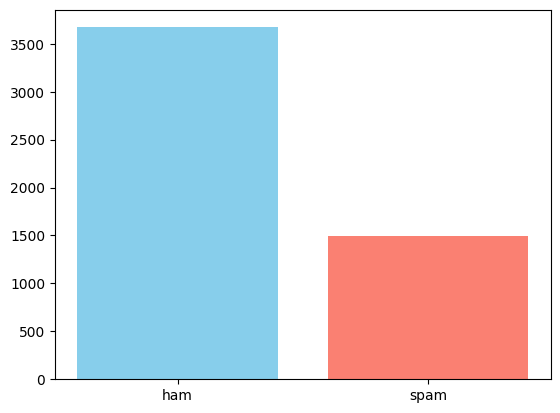

In [157]:
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, color=['skyblue', 'salmon'])

🧐 Observation:

In the dataset there aren't Nan values.

As usual in these use cases the target feature is unbalanced with the fail category (*spam*) with less samples (3672 vs 1499) and a $ \text{spam/ham ratio} = 0.41 $. 

During the training we're going to explore some methodologies like SMOTE, under and over sampling and check if those will give us better performance.

## Text length analysis 

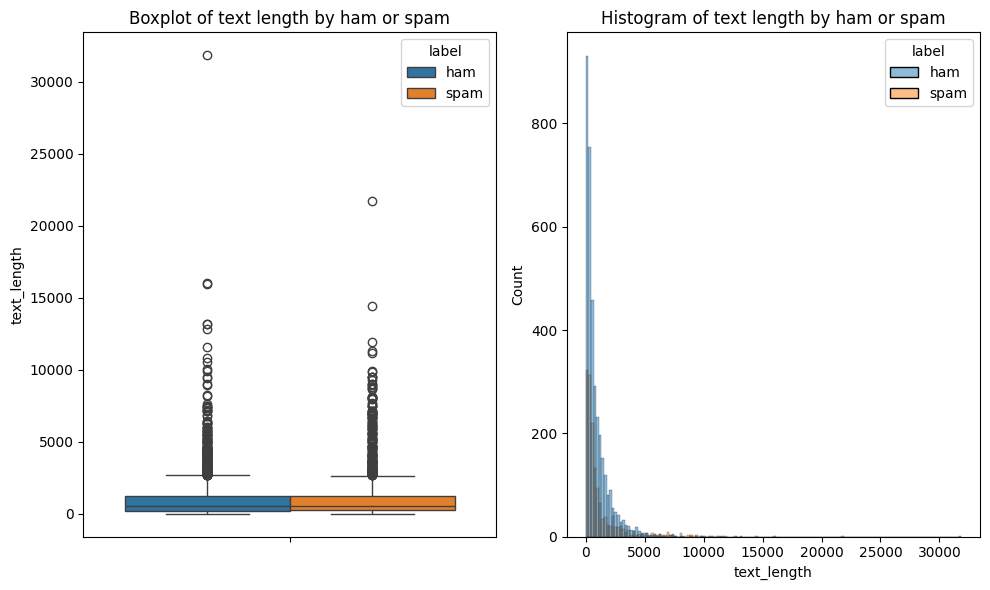

In [159]:
text_df = df[['label', 'clean_text']].copy()
text_df["text_length"] = text_df["clean_text"].str.len()

plt.figure(figsize=(10, 6))


plt.subplot(1, 2, 1)
sns.boxplot(y="text_length", data=text_df, hue="label", hue_order=["ham", "spam"])
plt.title("Boxplot of text length by ham or spam")

plt.subplot(1, 2, 2)
sns.histplot(x="text_length", data=text_df, hue="label", hue_order=["ham", "spam"])
plt.title("Histogram of text length by ham or spam")
plt.tight_layout()
plt.show()

🤔 Consideration:

In the histogram we can observe that the NO SPAM emails are more frequent in the left side of the text length distribution (could be due to class unbalance).

The boxplot shows the same behavior in the 2 label distributions about the text length.

In [160]:
nlp.disable_pipe("ner")
nlp.disable_pipe("parser")

In [161]:
df['tokens'] = df['clean_text'].apply(tokenize_text)

In [162]:
all_tokens = [t for doc in df["tokens"] for t in doc]
lengths = [len(t) for t in all_tokens]
iqr = np.percentile(lengths, 75) - np.percentile(lengths, 25)
upper_bound_outlier = np.percentile(lengths, 75) + 1.5 * iqr
median = np.median(lengths)

In [163]:
summary_txt = f"Median: {median}\nMin length outliers: {upper_bound_outlier}"

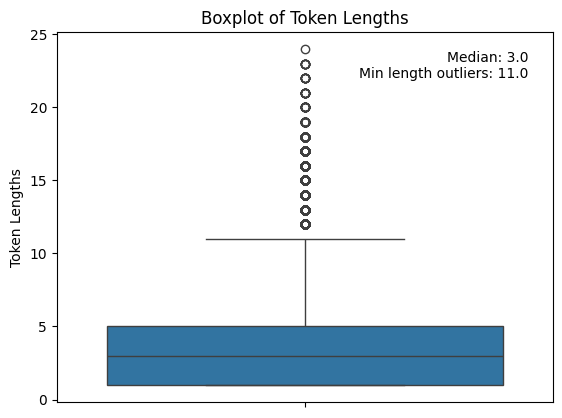

In [164]:
ax = sns.boxplot(lengths)
ax.set_title("Boxplot of Token Lengths")
ax.set_ylabel("Token Lengths")
ax.text(
    0.95, 0.95,              # alto a destra
    summary_txt,
    transform=ax.transAxes,  # coordinate relative all'asse
    ha='right',
    va='top',
    fontsize=10
)

plt.show()

## Topic Modeling on Spam

**Pre-processing**:

- ✔️ Lowercasing
- ✔️ Tokenization
- ✔️ Stopwords removal
- ✔️ Lemmatization
- ✔️ Punctuation removal
- ✔️ Token filtering (too short/long)
- ✔️ Word Embedding

In [165]:
df['tokens_cleaned'] = df['tokens'].apply(filter_tokens)

In [166]:
spam = df[df['label'] == 'spam']

In [167]:
documents_spam = spam['tokens_cleaned'].tolist()

In [168]:
word_freq = Counter()
for doc in documents_spam:
    word_freq.update(doc)

### LDA

In [169]:
# Dictionary
dictionary = corpora.Dictionary(documents_spam)
dictionary.filter_extremes(no_below=3, no_above=0.5)

# BoW
corpus = [dictionary.doc2bow(doc) for doc in documents_spam]
# LDA
lda_model = models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)

In [112]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"nbsp" + 0.009*"account" + 0.006*"money" + 0.006*"email" + '
  '0.005*"number" + 0.005*"claim" + 0.005*"million" + 0.005*"bank" + '
  '0.004*"address" + 0.004*"fund"'),
 (1,
  '0.023*"company" + 0.013*"statement" + 0.011*"stock" + 0.009*"information" + '
  '0.008*"report" + 0.008*"security" + 0.008*"investment" + 0.006*"price" + '
  '0.006*"inc" + 0.006*"look"'),
 (2,
  '0.013*"http" + 0.011*"pill" + 0.010*"com" + 0.008*"good" + 0.006*"price" + '
  '0.006*"online" + 0.006*"new" + 0.005*"viagra" + 0.005*"save" + '
  '0.005*"want"'),
 (3,
  '0.016*"com" + 0.012*"computron" + 0.010*"www" + 0.009*"contact" + '
  '0.008*"message" + 0.008*"remove" + 0.007*"free" + 0.006*"send" + '
  '0.006*"link" + 0.006*"mail"'),
 (4,
  '0.024*"font" + 0.020*"http" + 0.017*"height" + 0.014*"width" + 0.012*"size" '
  '+ 0.011*"align" + 0.011*"com" + 0.009*"border" + 0.009*"color" + '
  '0.009*"href"')]


In [113]:
lda_topics = lda_model.show_topics(
    num_topics=lda_model.num_topics,
    num_words=100,
    formatted=False
)

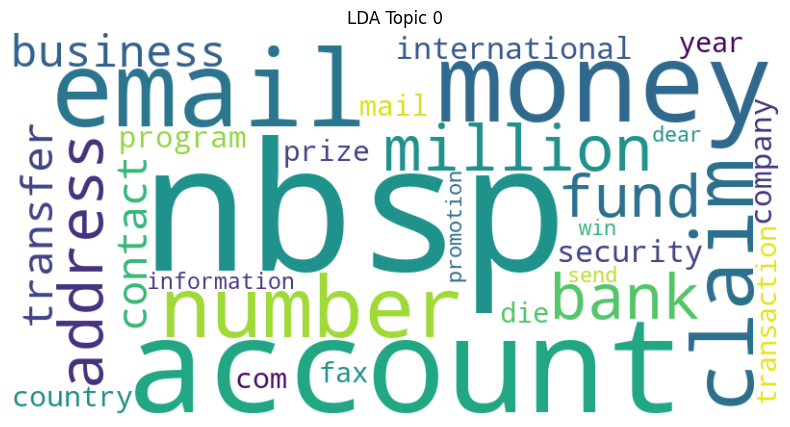

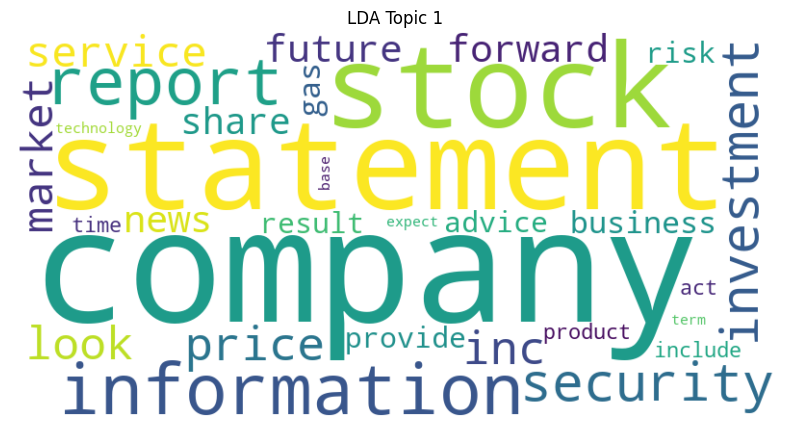

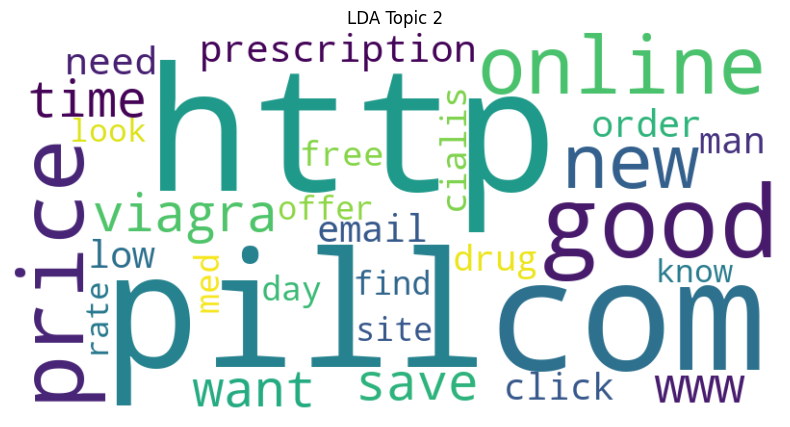

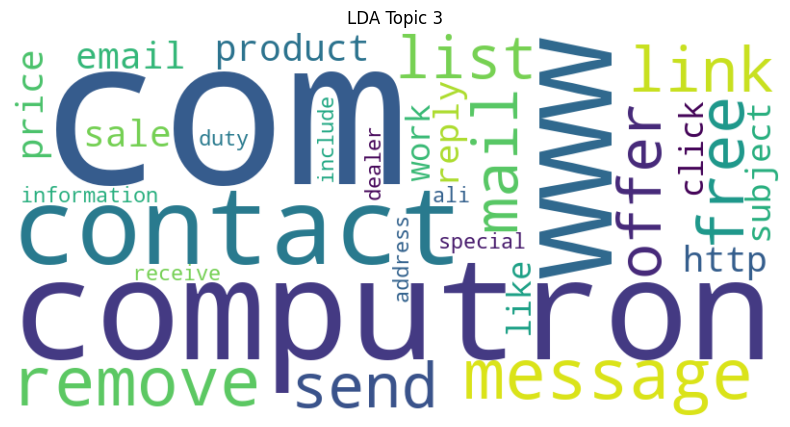

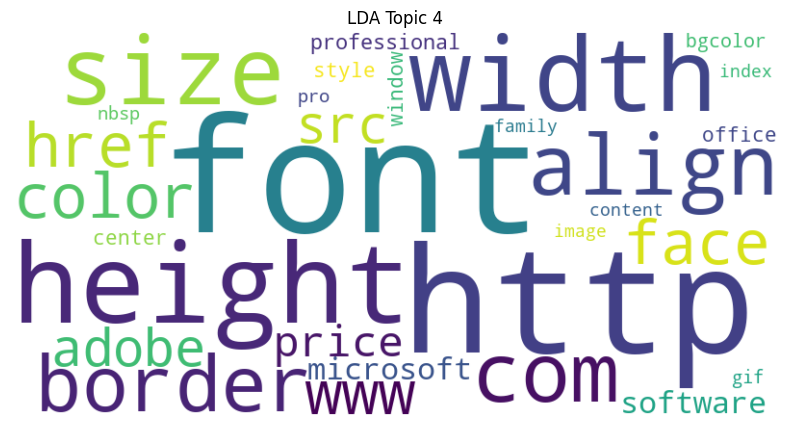

In [114]:
# WordCloud LDA Topics
for topic_id, words in lda_topics:
    word_freq = dict(words)
    get_word_cloud(words, word_freq, f"LDA Topic {topic_id}")

🔍 TOPIC DESCRIPTION

- **Topic 0: Financial Fraud, Lottery & Payment**: this topic is highly associated with financial scam like requests or promises of money, fake winnings, prizes, or blocked funds, requests for bank transfers, account, security, and contact information

    -> (*money, account, amount, fund, transfer, payment, dollar, prize, winner, security, contact, address, transaction*)

- **Topic 1: Business, Investment & Corporate Communication**: this topic concerns the world of business communication and speculative finance, these are emails promoting stock market investments, often linked to “pump and dump” schemes, the language used is that of financial reports and corporate communications to appear credible to potential investors

    -> (*company, statement, stock, investment, market, price, service, information, security, report, result, future, growth*)

- **Topic 2: Pharmaceutical & Product Promotion**: this topic focuses on the sale of medicines (often counterfeit) without the need for a prescription, the words emphasize savings and the ease of online purchasing, with specific references to male health products


    -> (*product, price, order, low, discount, online, click, buy, drug, prescription, viagra, cialis, free, cheap, shipping*)

- **Topic 3: Commercial Marketing and Mailing Lists**: this topic seems to group together generic commercial spam or unsolicited newsletters, It includes offers for various products and messages inviting recipients to click on links to “remove” themselves from a list or to view an offer, this is spam that attempts to generate traffic to specific websites or validate active email addresses

    -> (*computron, free, contact, remove, email, click, message, link, unsubscribe*)

- **Topic 4: Software and HTML Formatting (Technical)**: this topic  is a mix of software promotion and technical “noise” in messages, it reflects the sale of counterfeit or low-cost software (Adobe, Microsoft) and the massive presence of technical HTML terms indicates that the model has captured the structure of the code used to create graphically rich emails, typical of modern spam templates

    -> ( *http, font, width, size, height, href, color, adobe, microsoft, software, photoshop, windows.*)

### W2v + KMeans

In [115]:
w2v_model = Word2Vec(
    sentences=documents_spam,  # token's list
    vector_size=100,      # embedding's dimension
    window=5,             # context window
    min_count=3,          # iignore rare words
    workers=4,            # number of threads
    sg=1,                 # 1=skip-gram, 0=CBOW
    seed=42
)

In [116]:
vocab = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in vocab])

In [117]:
# KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(word_vectors)
word_clusters = {word: kmeans.labels_[i] for i, word in enumerate(vocab)}
cluster_centers = kmeans.cluster_centers_

In [118]:
word_freq = Counter()
for doc in documents_spam:
    word_freq.update(doc)

On the embedding clustering the weights of the words for the word clouds are calculated as a mix of the cosine distance (of the word form the centroid of its cluster) and the frequency of that word.

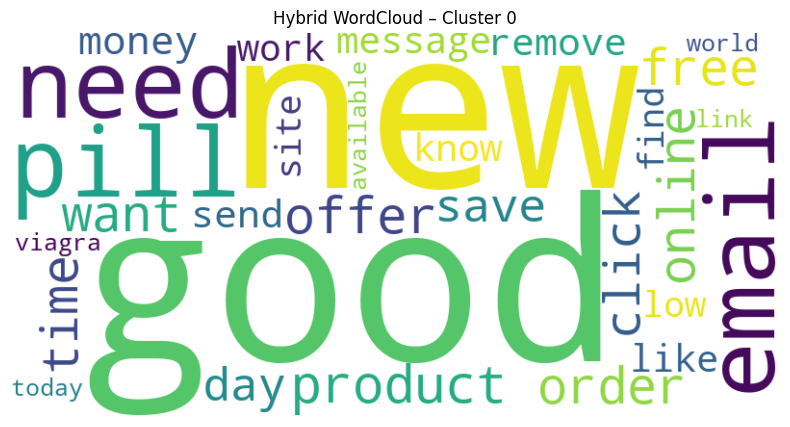

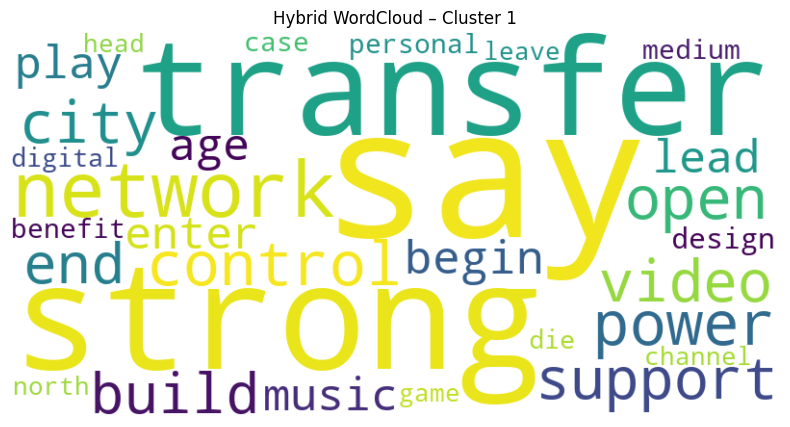

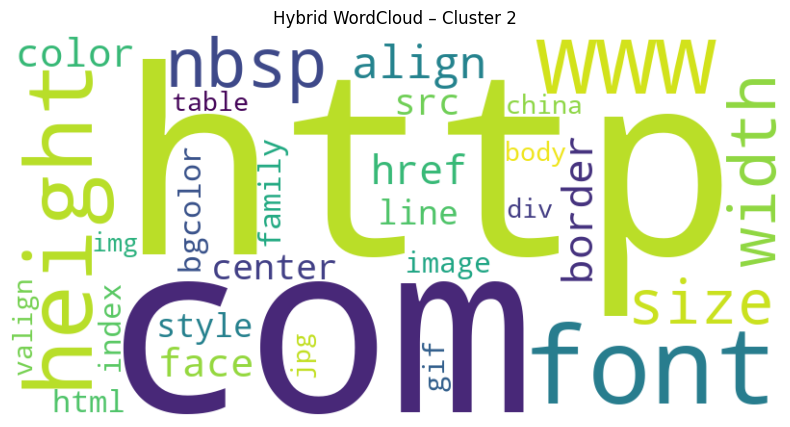

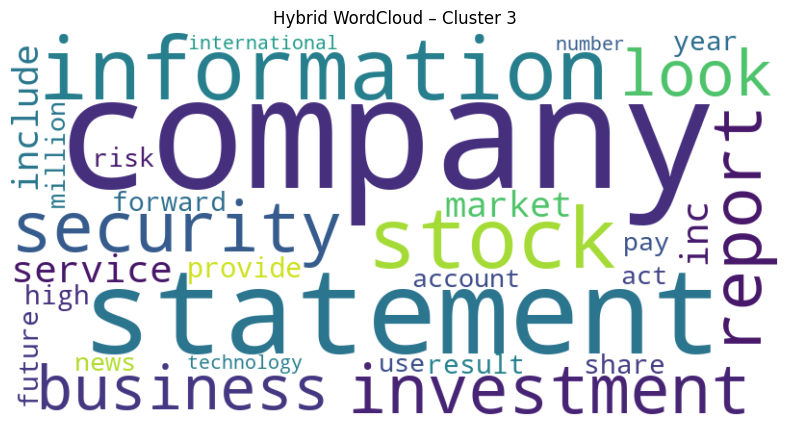

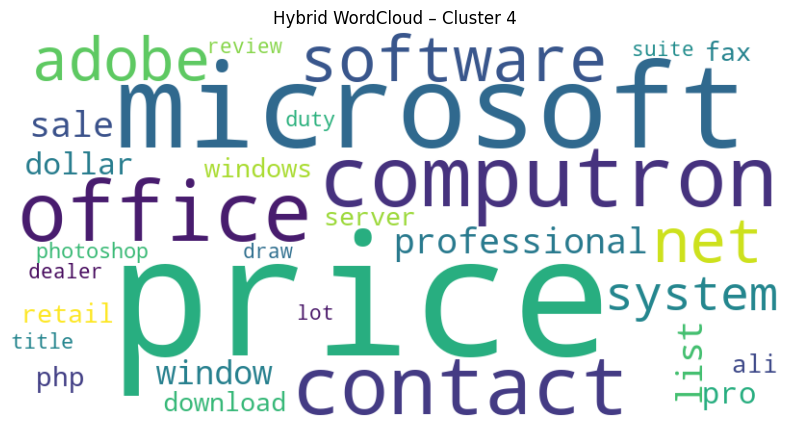

In [120]:
for cluster_id in range(num_clusters):
    cluster_words = [word for word, c in word_clusters.items() if c == cluster_id]


    weights = {}
    for word in cluster_words:
        sim = 1 - cosine(w2v_model.wv[word], cluster_centers[cluster_id])
        weights[word] = word_freq[word]*sim
    
    get_word_cloud(cluster_words, weights, f"Hybrid WordCloud – Cluster {cluster_id}")

🔍 CLUSTER DESCRIPTION

- **Cluster 0: Commercial Offers and Online Pharmacy**: This cluster aimed at the direct sale of products, with a strong emphasis on the pharmaceutical sector, focuses on promoting “new products” and “offers” at attractive prices

    -> (*price, new, pill, good, product, offer, viagra, order, online, free*);

- **Cluster 1: General Communication and Tech Services**: This cluster appears less specific than the previous ones, collecting emails that use conversational language or language related to network and entertainment services, seems to group emails that simulate discussions or offer multimedia services and technical support 

    -> (*system, think, say, network, video, user, support, play, music, power*);

- **Cluster 2: Technical Structure and Junk HTML**: This cluster is purely technical, represents the “noise” of the HTML code used to compose graphical spam emails 

    -> (*http, com, font, width, height, align, border, size, src, href, style*);

-  **Cluster 3: Corporate Finance and Stock Market**: This cluster is dedicated to fraud or promotions in the economic sphere 

    -> (*company, information, statement, stock, investment, security, report, share, business*);

- **Cluster 4: Professional Software Sales**: This cluster is highly vertical and focused on software distribution often counterfeit or at ridiculously low prices, the brands mentioned are the giants of the industry 

    -> (*microsoft, office, professional, adobe, window, suite, photoshop, macromedia, pro*)

### Comparison of 2 methods

In [121]:
lda_topics_dict = {topic_id: list(words) for topic_id, words in lda_topics}

In [122]:
topic_cluster_distr = pd.DataFrame(columns=['LDA_topic', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4'])

# For every LDA topic we calculate the distribution of words over KMeans clusters
for topic_id, words in lda_topics_dict.items():
    clusters_in_topic = []
    for word in words:
        #print(word)
        if word[0] in word_clusters.keys():
            clusters_in_topic.append(word_clusters[word[0]])
    counter = Counter(clusters_in_topic)
    topic_cluster_distr.at[topic_id, 'LDA_topic'] = topic_id
    for cluster_num in range(num_clusters):
        col_name = f'Cluster_{cluster_num}'
        topic_cluster_distr.at[topic_id, col_name] = counter.get(cluster_num, 0)
        
    #print(f"LDA Topic {topic_id} distribution over Word2Vec clusters: {counter}")


In [123]:
topic_cluster_distr

,LDA_topic,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,0,31,11,4,49,5
1,1,11,1,0,85,3
2,2,89,0,3,5,3
3,3,53,2,5,14,26
4,4,18,4,42,2,34


🤔 Consideration

The distribution of the words frequencies between *Clusters* and *Topics* is alligned with their contents. We can assert that there are some main topics in the spam emails:
- Business and Corporate communications, Financial fraud and Lottery win
- Pharmaceutical and product promotion
- Software promotion and HTML formatting
- Marketing and commercial offers

### Semantic distance

In [124]:
# Vetorization of LDA topics and KMeans clusters
lda_vectors = {
    topic_id: topic_embedding(words, w2v_model)
    for topic_id, words in lda_topics_dict.items()
}
cluster_vectors = {i: np.mean([w2v_model.wv[w] for w, c in word_clusters.items() if c==i], axis=0) for i in range(num_clusters)}

In [125]:
# Compute distance matrix between LDA topics and KMeans clusters to check their semantic similarity
dist_matrix_tc = np.array([[0.0 for _ in range(len(lda_vectors))] for _ in range(len(lda_vectors))])
for t1_id, t1_vector in lda_vectors.items():
    for t2_id, t2_vector in cluster_vectors.items():
            dist_matrix_tc[t1_id][t2_id] = cosine(t1_vector, t2_vector)
            # print(f"Distance Topic {t1_id} - Cluster {t2_id}: {dist_matrix_tc[t1_id][t2_id]:.3f}")

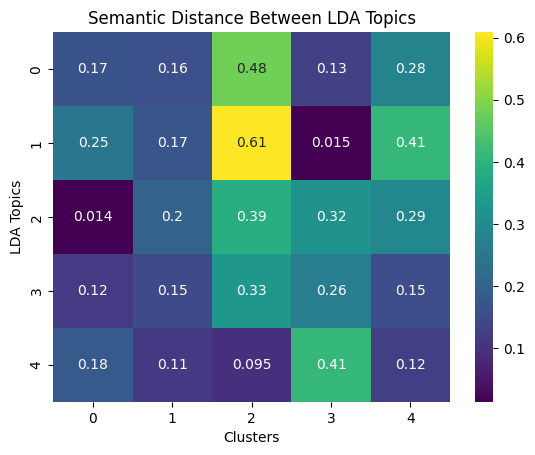

In [126]:
sns.heatmap(dist_matrix_tc, annot=True, cmap="viridis")
plt.title("Semantic Distance Between LDA Topics")
plt.xlabel("Clusters")
plt.ylabel("LDA Topics")
plt.show()

🤔 Consideration

With this visualization of semantic distance between LDA topics and KMeans Clusters we can measure the coerence between the 2 methods of finding groups of similar spam emails.

In this case we evaluate the most similar groups like:
- Topic 0 -> Cluster 3, 1
- Topic 1 -> Cluster 3
- Topic 2 -> Cluster 0
- Topic 3 -> Cluster 0, 1
- Topic 4 -> Cluster 2, 4

In [127]:
# Compute distance matrix between LDA topics to check how much they differ semantically
dist_matrix_topics = np.array([[0.0 for _ in range(len(lda_vectors))] for _ in range(len(lda_vectors))])
mask = np.triu(np.ones_like(dist_matrix_topics, dtype=bool))
for t1_id, t1_vector in lda_vectors.items():
    for t2_id, t2_vector in lda_vectors.items():
        if t1_id < t2_id:
            dist_matrix_topics[t1_id][t2_id] = cosine(t1_vector, t2_vector)
            dist_matrix_topics[t2_id][t1_id] = cosine(t1_vector, t2_vector)
            print(f"Distance Topic {t1_id}-{t2_id}: {dist_matrix_topics[t1_id][t2_id]:.3f}")

Distance Topic 0-1: 0.146
Distance Topic 0-2: 0.199
Distance Topic 0-3: 0.102
Distance Topic 0-4: 0.290
Distance Topic 1-2: 0.278
Distance Topic 1-3: 0.255
Distance Topic 1-4: 0.417
Distance Topic 2-3: 0.143
Distance Topic 2-4: 0.218
Distance Topic 3-4: 0.156


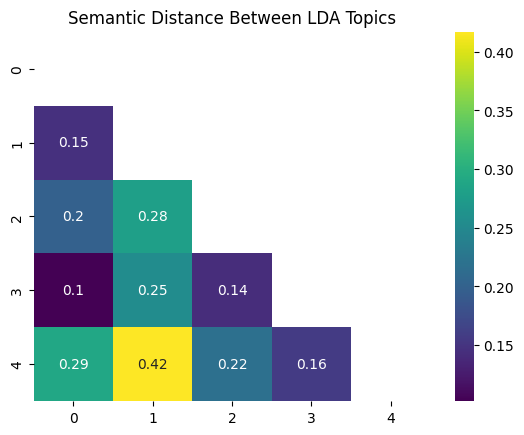

In [128]:
sns.heatmap(dist_matrix_topics, annot=True, cmap="viridis", mask=mask)
plt.title("Semantic Distance Between LDA Topics")
plt.show()

🤔 Consideration

In the semantic distance analysis between LDA topics we can observe only a slightly separation of the groups with cosine distance in range [0.11, 0.29]. The two topics with the most semantic difference are 1 and 4 with a value of 0.41 (not even that high). So the topics are very similar each other.

This could be due to the common lexicon used in the spam-type emails, even with different target areas (financial, pharmaceutical, software).

## NER: find organizations in NON-SPAM e-mails

**Pre-processing**:

- ✔️ Tokenization
- ✔️ Case sentsitive (don't modify)
- ✔️ Punctuation sensitive (don't modify)
- ✔️ NO stopword removal
- ✔️ NO lemmatization

In [129]:
nlp.enable_pipe("ner")
nlp.enable_pipe("parser")

In [130]:
no_spam = df[df['label'] == 'ham'].copy()

In [131]:
no_spam = no_spam.drop(columns=['tokens', 'tokens_cleaned'])

In [132]:
no_spam['clean_text_meta'] = no_spam['clean_text'].apply(clean_email_metadata)

In [133]:
ORG_PATTERNS = [
    {"label": "ORG", "pattern": "Enron"},
    {"label": "ORG", "pattern": "Enron Corp"},
    {"label": "ORG", "pattern": "Enron North America"},
    {"label": "ORG", "pattern": "Exxon"},
    {"label": "ORG", "pattern": "ExxonMobil"},
    {"label": "ORG", "pattern": "Chevron"},
    {"label": "ORG", "pattern": "Texaco"},
    {"label": "ORG", "pattern": "Mobil"},
    {"label": "ORG", "pattern": "PG & E"},
    {"label": "ORG", "pattern": "Pacific Gas & Electric"},
    {"label": "ORG", "pattern": "FERC"},
    {"label": "ORG", "pattern": "SEC"},
    {"label": "ORG", "pattern": "Citibank"},
    {"label": "ORG", "pattern": "Microsoft"},
    {"label": "ORG", "pattern": "Yahoo"},
    {"label": "ORG", "pattern": "Amazon"},
    {"label": "ORG", "pattern": "IBM"},
    {"label": "ORG", "pattern": "Boeing"},
    {"label": "ORG", "pattern": "Reuters"},
    {"label": "ORG", "pattern": "Duke Energy"},
    {"label": "ORG", "pattern": "Dynegy"},
    {"label": "ORG", "pattern": "Union Carbide"},
    {"label": "ORG", "pattern": "American Express"},
    {"label": "ORG", "pattern": "United Airlines"},
    {"label": "ORG", "pattern": "Blockbuster"},
    {"label": "ORG", "pattern": "Wal-Mart"},
    {"label": "ORG", "pattern": "Fidelity Investments"},
]


In [134]:
BLOCK_PATTERNS = [
    # metadata / routing
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": ".*/.*"}}]},
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": ".*@.*"}}]},
    
    # not printable characters
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": ".*\\x01.*"}}]},
    
    # file / extensions
    {"label": "ORG", "pattern": "xls"},
    {"label": "ORG", "pattern": "doc"},
    {"label": "ORG", "pattern": "gif"},
    {"label": "ORG", "pattern": "pdf"},
    
    # general tokens
    {"label": "ORG", "pattern": "http"},
    {"label": "ORG", "pattern": "https"},
    {"label": "ORG", "pattern": "www"},
    {"label": "ORG", "pattern": "org"},
]


In [135]:
ORG_NORMALIZATION = {

    # =====================
    # ENRON & SUBSIDIARIES
    # =====================
    "enron": "Enron",
    "enron corp .": "Enron",
    "enron corp eb": "Enron",
    "the enron corp .": "Enron",
    "enron corp the": "Enron",
    "enron north america": "Enron",
    "enron north america corp .": "Enron",
    "north america corp .": "Enron",
    "north america corp": "Enron",
    "enron north america corp": "Enron",
    "enron methanol": "Enron",
    "enron americas": "Enron",
    "enron south america": "Enron",
    "enron canada": "Enron",
    "enron europe": "Enron",
    "enron broadband": "Enron",
    "enron broadband services": "Enron",
    "enron wholesale services": "Enron",
    "enron field services": "Enron",
    "enron capital & trade resources corp .": "Enron",
    "enron methanol": "Enron",
    "ecs project enron net works": "Enron",
    "enron corp eb": "Enron",
    "enron corp meter": "Enron",
    "enron corp and": "Enron",
    "enron actuals - dec .": "Enron",
    "enron corp . '": "Enron",
    "bankrupt enron corp . '": "Enron",
    "jdf representing enron": "Enron",
    "dell & enron clickathome": "Enron",
    "dell & enron": "Enron",
    "enron south america": "Enron",
    "enron u .": "Enron",

    # =====================
    # ENERGY / OIL & GAS
    # =====================
    "exxon": "Exxon",
    "exxon company": "Exxon",
    "exxon katy": "Exxon",
    "exxon - katy": "Exxon",
    "exxon clear lake": "Exxon",
    "exxon clear": "Exxon",
    "exxon vance": "Exxon",
    "exxon king ranch": "Exxon",
    "exxonmobil beaumont": "ExxonMobil",

    "mobil": "Mobil",
    "mobil beaumont": "Mobil",
    "mobil - beaumont": "Mobil",
    "mobil florida": "Mobil",
    "mobil chemical": "Mobil",

    "chevron": "Chevron",
    "texaco": "Texaco",
    "chevrontexaco": "ChevronTexaco",
    "amoco": "Amoco",
    "conoco": "Conoco",
    "conoco , inc .": "Conoco",
    "phillips": "Phillips Petroleum",
    "phillips petroleum , inc .": "Phillips Petroleum",
    "tesoro": "Tesoro",

    "wagner" : "Wagner & Brown Ltd",
    "wagner brown" : "Wagner & Brown Ltd",
    "wagner oil company" : "Wagner & Brown Ltd",
    "wagner & brown" : "Wagner & Brown Ltd",
    "wagner & brown ltd" : "Wagner & Brown Ltd",
    "wagner & brown ltd 989603" : "Wagner & Brown Ltd",
    "wagner & brown , ltd ." : "Wagner & Brown Ltd",

    "walter o & g" : "Walter Oil & Gas",
    "walter o & g 9808 4" : "Walter Oil & Gas",
    "walter o & g 9747 3" : "Walter Oil & Gas",
    "walter o & g 9787 1" : "Walter Oil & Gas",
    "walter o & g 0435" : "Walter Oil & Gas",
    "walter oil &" : "Walter Oil & Gas",

    "kerr mcgee": "Kerr-McGee",
    "kerr - mcgee": "Kerr-McGee",
    "kerr - mcgee oil & gas": "Kerr-McGee",
    "kerr mcgee oil & gas": "Kerr-McGee",
    "kerr - mcgee '": "Kerr-McGee",
    "kerr mcgee :": "Kerr-McGee",

    # =====================
    # UTILITIES / PIPELINES
    # =====================
    "pg & e": "PG&E",
    "pg & e .": "PG&E",
    "pg & e texas": "PG&E",
    "pg & e texas pipeline": "PG&E",
    "pg & e ' s": "PG&E",
    "pg & e and": "PG&E",
    "pg &": "PG&E",
    "sullivan pg &": "PG&E",
    "pg & e w": "PG&E",
    "pg & e discrepancy": "PG&E",
    "pg & e ntp - 36": "PG&E",
    "the pg & e contract": "PG&E",
    "pg & e texas 11": "PG&E",
    "pg & e to": "PG&E",
    "hpl pg &": "PG&E",
    "pg & e (": "PG&E",
    "kellie , pg & e": "PG&E",
    "pg & e . 7": "PG&E",
    "pg & e 7": "PG&E",
    "pg & e won '": "PG&E",
    "pg & e ' s system": "PG&E",

    "txu": "TXU",
    "duke": "Duke Energy",
    "duke energy": "Duke Energy",
    "duke energy & trading": "Duke Energy",
    "duke energy trading & mktg": "Duke Energy",

    "tenaska": "Tenaska",
    "tenaska , inc": "Tenaska",
    "tenaska gas company": "Tenaska",
    "tenaska gas management": "Tenaska",
    "tenaska gas management agreement": "Tenaska",

    "dynegy inc .": "Dynegy",
    "southern union - 03": "Southern Union",
    "southern union": "Southern Union",
    "southern union gas company": "Southern Union",
    "aquila": "Aquila",
    "midcon": "Midcon",
    "midcon texas": "Midcon",
    "midcon texas pipeline": "Midcon",

    "cp & l" : "CP&L",
    "& l" : "CP&L",
    "central power &" : "CP&L",
    
    "final version rohm & haas" : "Rohm & Haas",
    "rohm & haas" : "Rohm & Haas",
    
    # =====================
    # FINANCIAL / BANKS
    # =====================
    "citibank": "Citibank",
    "citigroup inc .": "Citigroup",
    "chase manhattan corporation": "Chase Manhattan",
    "chase manhattan bank": "Chase Manhattan",
    "american express": "American Express",
    "american express financial advisors": "American Express",
    "fidelity investments": "Fidelity Investments",
    "ubs ag": "UBS",
    "lehman": "Lehman Brothers",
    "painewebber": "PaineWebber",

    # =====================
    # TECH / MEDIA
    # =====================
    "microsoft": "Microsoft",
    "ibm": "IBM",
    "yahoo": "Yahoo",
    "yahoo !": "Yahoo",
    "yahoo - inc": "Yahoo",
    "amazon": "Amazon",
    "reuters": "Reuters",
    "nbc": "NBC",
    "cbs": "CBS",
    "fox": "Fox",
    "intuit inc .": "Intuit",

    # =====================
    # INDUSTRIAL / OTHER CORPS
    # =====================
    "boeing": "Boeing",
    "union carbide": "Union Carbide",
    "union carbide corporation equistar chemicals": "Union Carbide",
    "blockbuster inc .": "Blockbuster",
    "blockbuster inc": "Blockbuster",
    "sears": "Sears",
    "wal - mart": "Walmart",
    "mcdonald ' s": "McDonald's",
    "deloitte & touche": "Deloitte",
    "rockwell": "Rockwell",

    # =====================
    # INSTITUTIONS / GOVERNMENT
    # =====================
    "ferc": "FERC",
    "ferc houston": "FERC",
    "sec": "SEC",
    "securities and exchange commission": "SEC",
    "the securities and exchange commission": "SEC",
    "irs": "IRS",
    "fbi": "FBI",
    "senate": "US Senate",
    "the senate commerce committee": "US Senate",
    "the house of representatives financial services committee": "US Congress",
    "united states": "United States",

}

In [136]:
EXCLUDED_ORGS = ["xls", "doc", "gif", "pdf", "org", "www", "http", "https", "org"]

In [137]:
ruler = nlp.add_pipe("entity_ruler", before="ner")
ruler.add_patterns(BLOCK_PATTERNS)
ruler.add_patterns(ORG_PATTERNS)

In [138]:
no_spam['doc'] = no_spam['clean_text_meta'].apply(lambda x: nlp(x))

In [139]:
no_spam['orgs'] = no_spam['doc'].apply(extract_clean_orgs)

In [140]:
org_to_contexts = defaultdict(list)

for _, row in no_spam.iterrows():
    for org in row["orgs"]:
        org_to_contexts[org].append(row["clean_text_meta"])


In [141]:
org_counter = Counter(
    org for sublist in no_spam["orgs"] for org in sublist if org not in EXCLUDED_ORGS
)

In [142]:
org_to_plot = dict(org_counter.most_common(50))

### Frequencies

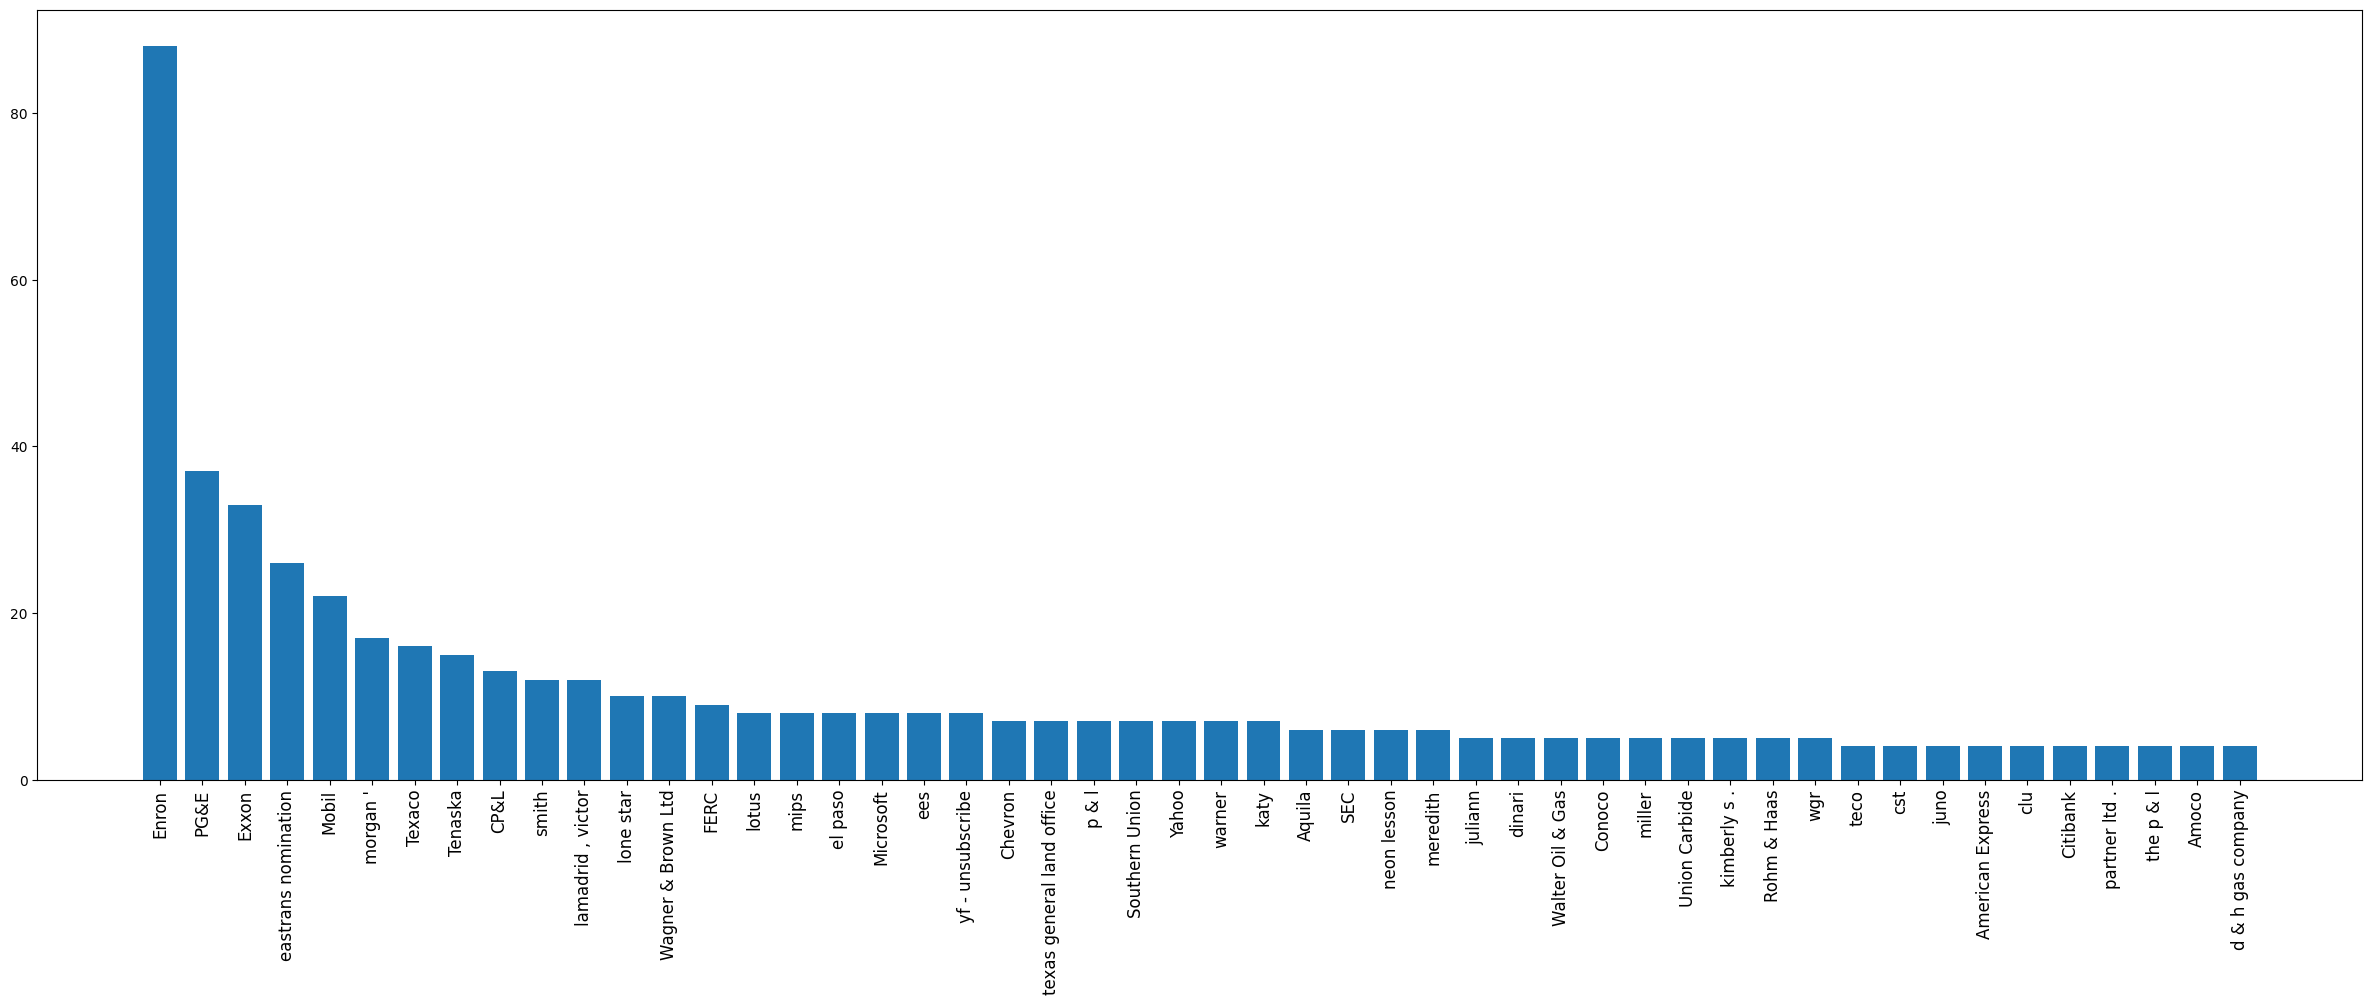

In [143]:
# BAR CHART
plt.figure(figsize=(30,10))
plt.bar(org_to_plot.keys(), org_to_plot.values())
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [144]:
df_org_freq = pd.DataFrame.from_dict(org_counter, orient='index', columns=['Frequency'])
df_org_freq = df_org_freq.reset_index().rename(columns={'index': 'ORG'})    
org_freq = df_org_freq.sort_values(by='Frequency', ascending=False)
org_freq['Cumulative_Percentage'] = org_freq['Frequency'].cumsum() / org_freq['Frequency'].sum() * 100
org_freq = org_freq.reset_index(drop=True)

In [145]:
len(org_freq)

651

In [146]:
# cell to check the ORGANIZATIONS
#str_search = "morgan"
#search_organizations(str_search, org_freq, org_to_contexts)

C:\Users\Tia\AppData\Local\Temp\ipykernel_20624\401443770.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(org_freq['ORG'], rotation=45, ha='right', fontsize=8)
C:\Users\Tia\AppData\Local\Temp\ipykernel_20624\401443770.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


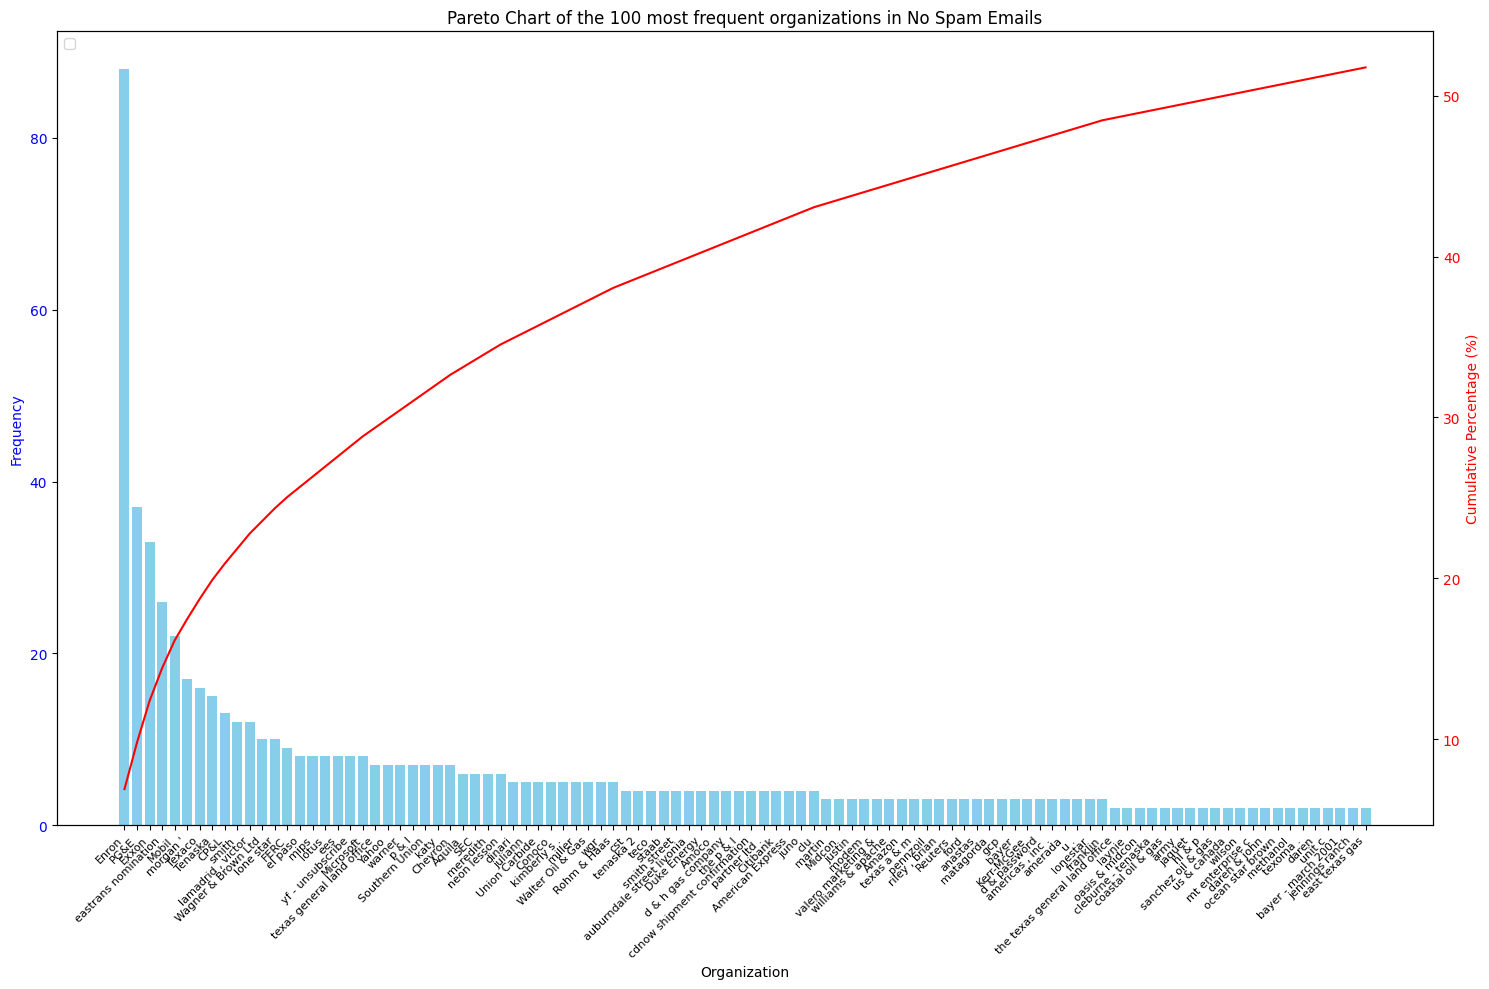

In [147]:
# PARETO CHART

# Filter
org_freq_filter = org_freq[org_freq['Frequency'] >= 5]
org_freq_filter = org_freq[:100]

# PLOT
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.bar(org_freq_filter['ORG'], org_freq_filter['Frequency'], color='skyblue')
ax1.set_xlabel('Organization')
ax1.set_xticklabels(org_freq['ORG'], rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Cumulative Percentage Line
ax2 = ax1.twinx()
ax2.plot(org_freq_filter['ORG'], org_freq_filter['Cumulative_Percentage'], color='red', 
         linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
#ax2.axhline(80, color='green', linestyle='--', label='80% Threshold')

plt.title('Pareto Chart of the 100 most frequent organizations in No Spam Emails')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


🤔  Consideration:

From the histogram of the frequencies we can see that 3 main organizations are cited in the no spam emails: Enron, PG&E, Exxon.

The Pareto chart perfomed only on the 100 most frequent (over 651, so 15%) organizations shows that the 50% of the mails cointain just 100 of the total organizations. This case isn't complied with the usual pareto distribution (80-20), however shows that a small part of the organizations cover half of the distribution.


### Co-Occurrences

In [148]:
co_occurrence = Counter()

for orgs in no_spam["orgs"]:
    if len(orgs) > 1:
        for pair in combinations(sorted(set(orgs)), 2):
            co_occurrence[pair] += 1

In [149]:
G = nx.Graph()

for (org1, org2), weight in co_occurrence.items():
    if weight >= 3: 
        G.add_edge(org1, org2, weight=weight)

In [150]:
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

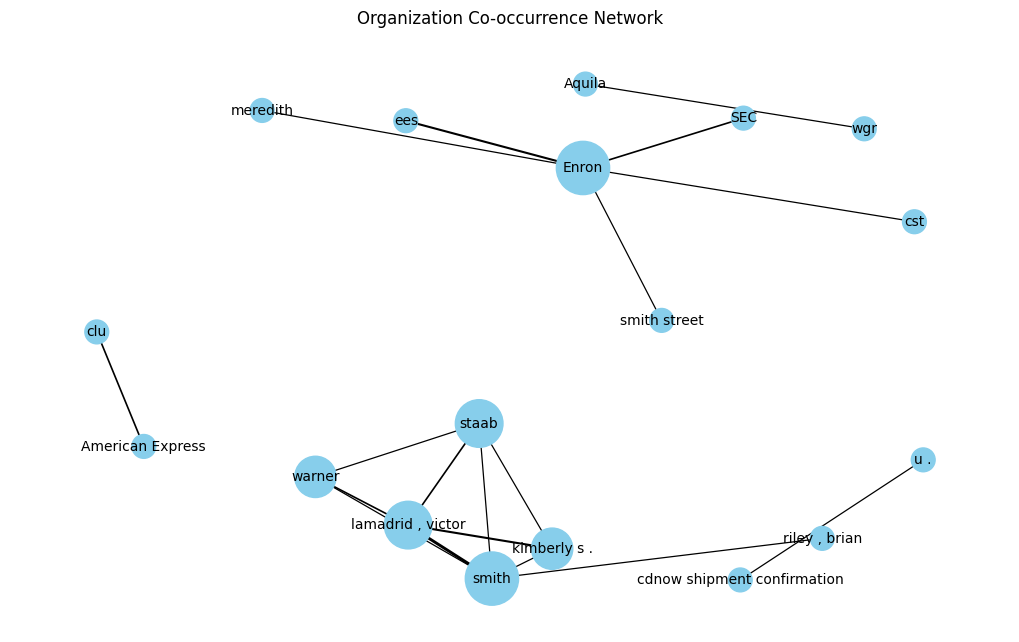

In [151]:
# co-occurence network visualization
plt.figure(figsize=(10, 6))

pos = nx.spring_layout(G, k=1.5, seed=42)
node_sizes = [5000 * degree_centrality[node] for node in G.nodes()]

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    font_size=10,
    width=[G[u][v]['weight'] * 0.3 for u, v in G.edges()],
    node_color='skyblue'
)

plt.title("Organization Co-occurrence Network")
plt.show()

🤔 Consideration:

The organization co-occurrence network reveals Enron as the central coordination hub, connecting regulatory bodies, operational units, and external partners, while also highlighting smaller, domain-specific communication clusters.

### Context

In [152]:
context_1 = ['Enron', 'ees', 'cst', 'meredith', 'smith street', 'SEC', 'Aquila', 'wgr']
context_2 = ['lamadrid , victor', 'smith', 'staab', 'warner', 'kimberly s .', 'riley , brian', 'cdnow shipment confirmation', 'u .', 'American Express', 'clu']

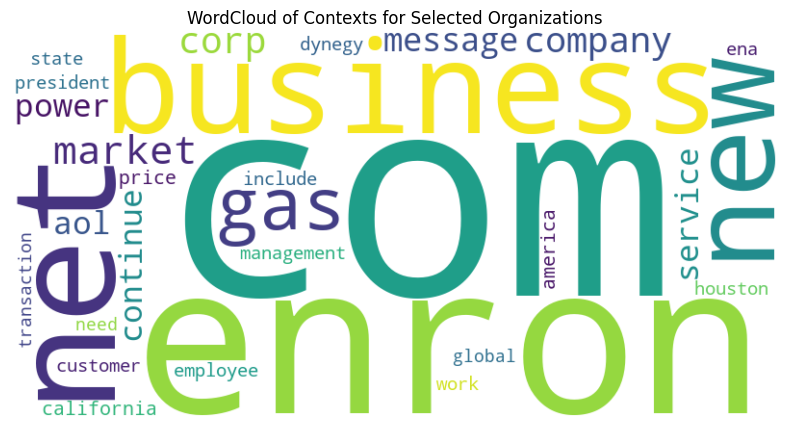

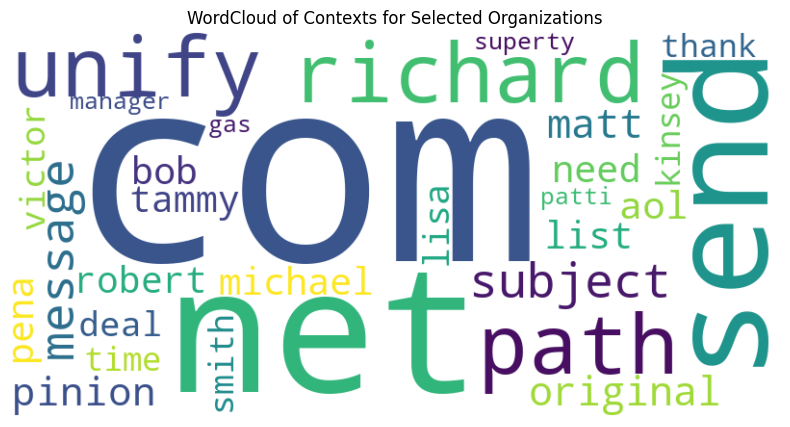

In [153]:
for context in [context_1, context_2]:
    raw_contexts = get_context_or_organizations(context, org_to_contexts)
    tokens_contexts = [filter_tokens(tokenize_text(doc)) for doc in raw_contexts]
    all_tokens = [t for mail in tokens_contexts for t in mail]
    freqs = Counter(all_tokens)
    get_word_cloud(all_tokens, freqs, "WordCloud of Contexts for Selected Organizations")

🤔 Consideration:

From the netwotk graph we got 2 main context where we can find a subset of organizations. Those two communities are represent in the two word clouds above. There's not a big diffence in the two word clouds, catches the eye on emphasis of some words bigger in one contex than in the other (but present in both anyway). The most representative words are *enron, gas, net, com, send, business, message, management*.

# Classifier Model

**Pre-processing**:

- ✔️ Lowercasing
- ✔️ Tokeniztion
- ✔️ Stopwords removal
- ✔️ Lemmatization
- ✔️ Punctuation removal
- ✔️ Token filtering (rare)

In [68]:
X = df['text']
y = df['label_num']

In [69]:
nlp_clf = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [74]:
random_seed = 42

In [77]:
scaler = StandardScaler()
tfidf = TfidfVectorizer(max_df=0.9,          
                        min_df=3,
                        max_features=10000,
                        ngram_range=(1,2))
tfidf_no_norm = TfidfVectorizer(max_df=0.9,          
                        min_df=3,
                        max_features=10000,
                        ngram_range=(1,2),
                        norm=None
                        )
w2v = Word2VecVectorizer()
sample_weight = np.where(y == 1, 2.4, 1.0)

In [82]:
svm = LinearSVC(C=1.0, class_weight="balanced", max_iter=3000, random_state=random_seed)

In [83]:
calibrated_svm = CalibratedClassifierCV(
    svm,
    method="sigmoid",  # oppure "isotonic" (più dati)
    cv=5
)

In [ ]:
# creating the list for models
List_Classification_Models =[]
List_Classification_Models.append(('LR', LogisticRegression(l1_ratio=0,   # L2 regularization
                                                            C=1.0,
                                                            solver="liblinear",
                                                            max_iter=1000,
                                                            class_weight="balanced",
                                                            random_state=random_seed), 
                                   TextPreprocessor(nlp_clf, output='string'), 'passthrough', tfidf, None))
List_Classification_Models.append(('LR', LogisticRegression(l1_ratio=0,   # L2 regularization
                                                            C=1.0,
                                                            solver="lbfgs",
                                                            max_iter=1000,
                                                            class_weight="balanced",
                                                            random_state=random_seed),  
                                   TextPreprocessor(nlp_clf, output='tokens'), scaler, w2v, None))

List_Classification_Models.append(('LinearSVC', calibrated_svm,
                                    TextPreprocessor(nlp_clf, output='string'), 'passthrough', tfidf, None))
List_Classification_Models.append(('LinearSVC', calibrated_svm,
                                    TextPreprocessor(nlp_clf, output='tokens'), scaler, w2v, None))

List_Classification_Models.append(('Multinomial_NB', MultinomialNB(alpha=1.0),
                                   TextPreprocessor(nlp_clf, output='string'), 'passthrough', tfidf_no_norm, None))

List_Classification_Models.append(('RF', RandomForestClassifier(n_estimators=300,
                                                                max_depth=7,
                                                                min_samples_split=5,
                                                                min_samples_leaf=2,
                                                                max_features="sqrt",
                                                                class_weight="balanced", 
                                                                random_state=random_seed,
                                                                n_jobs=-1),
                                   TextPreprocessor(nlp_clf, output='string'), 'passthrough', tfidf, None))

List_Classification_Models.append(('XGB', xgb.XGBClassifier(n_estimators=200,
                                                            max_depth=6,
                                                            learning_rate=0.1,
                                                            subsample=0.8,
                                                            colsample_bytree=0.8,
                                                            scale_pos_weight=2.4,  # ≈ 1 / 0.41
                                                            objective="binary:logistic",
                                                            eval_metric="auc",
                                                            random_state=random_seed),
                                   TextPreprocessor(nlp_clf, output='tokens'),'passthrough', w2v, None))

List_Classification_Models.append(('LightGBM', LGBMClassifier(objective='binary',
                                                            n_estimators=300,
                                                            learning_rate=0.1,
                                                            num_leaves=31,           
                                                            subsample=0.8,
                                                            colsample_bytree=0.8,
                                                            max_depth=7,
                                                            verbosity=-1,
                                                            scale_pos_weight=2.4,  # ≈ 1 / 0.41
                                                            random_state=random_seed),
                                   TextPreprocessor(nlp_clf, output='tokens'), 'passthrough', w2v, None))

List_Classification_Models.append(('MLP', MLPClassifier(hidden_layer_sizes=(100,),
                                                        activation='relu',           
                                                        solver='adam', 
                                                        alpha=0.0001,
                                                        learning_rate_init=0.001,
                                                        max_iter=300,            
                                                        early_stopping=True, 
                                                        n_iter_no_change=5,
                                                        validation_fraction=0.05,
                                                        tol=1e-3,        
                                                        random_state=random_seed),
                                   TextPreprocessor(nlp_clf, output='tokens'), scaler, w2v, sample_weight))

In [ ]:
results = []

for name, model, preprocessor, scaler, vectorizer, sample_weight in List_Classification_Models:

    pipe = make_pipeline(name, model, preprocessor, scaler, 
                         vectorizer=vectorizer, 
                         random_seed=random_seed)
    
    start_time = time.time()
    #print(pipe.steps)
    if sample_weight is None:
        pipe.fit(X_train, y_train)
    else:
        pipe.fit(X_train, y_train, **{name + '__sample_weight': sample_weight})
        
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    result = get_performance_metrics(y_test, y_pred, y_proba, name + " " + vectorizer.__class__.__name__)   
    results.append(result)
    
    print(f"Finish training {name} Time: {int(minutes)} min {seconds:.2f} sec")

    
# converti in DataFrame i risultati
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

[('preprocessor', TextPreprocessor(nlp=<spacy.lang.en.English object at 0x0000023F2504A420>,
                 output='string')), ('vectorizer', TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3, ngram_range=(1, 2))), ('scaler', 'passthrough'), ('LR', LogisticRegression(class_weight='balanced', l1_ratio=0, max_iter=1000,
                   random_state=42, solver='liblinear'))]
Finish training LR Time: 1 min 11.84 sec
[('preprocessor', TextPreprocessor(nlp=<spacy.lang.en.English object at 0x0000023F2504A420>)), ('vectorizer', Word2VecVectorizer()), ('scaler', 'passthrough'), ('LR', LogisticRegression(class_weight='balanced', l1_ratio=0, max_iter=1000,
                   random_state=42))]
Finish training LR Time: 1 min 10.74 sec
[('preprocessor', TextPreprocessor(nlp=<spacy.lang.en.English object at 0x0000023F2504A420>,
                 output='string')), ('vectorizer', TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3, ngram_range=(1, 2))), ('scaler', 'passthrough'), ('Li

c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Finish training LightGBM Time: 1 min 32.48 sec
[('preprocessor', TextPreprocessor(nlp=<spacy.lang.en.English object at 0x0000023F2504A420>)), ('vectorizer', Word2VecVectorizer()), ('scaler', 'passthrough'), ('MLP', MLPClassifier(early_stopping=True, max_iter=300, n_iter_no_change=5,
              random_state=42, tol=0.001, validation_fraction=0.05))]
Finish training MLP Time: 1 min 16.19 sec


In [86]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
2,LinearSVC TfidfVectorizer,0.987440,0.970492,0.986667,0.978512,0.999043
7,LightGBM Word2VecVectorizer,0.983575,0.966997,0.976667,0.971808,0.997882
6,XGB Word2VecVectorizer,0.978744,0.951299,0.976667,0.963816,0.997973
3,LinearSVC Word2VecVectorizer,0.972947,0.935897,0.973333,0.954248,0.994494
0,LR TfidfVectorizer,0.967150,0.903030,0.993333,0.946032,0.998054
4,Multinomial_NB TfidfVectorizer,0.966184,0.920635,0.966667,0.943089,0.984367
1,LR Word2VecVectorizer,0.957488,0.880952,0.986667,0.930818,0.992662
8,MLP Word2VecVectorizer,0.949758,0.878049,0.960000,0.917197,0.988621
5,RF TfidfVectorizer,0.890821,0.726392,1.000000,0.841515,0.989190


🤔 Consideration:

All the models (on hold out split) show good performances with almost all over 95% of accuracy, recall, F1 score, The Roc Auc values are very high over 98%.

To evaluate if those metrics are roboust will be performed with the best 3 the Cross Validation.


## Cross Validation

In [90]:
def extract_params(param_list, name_model, vectorizer=None):
    '''
    Extract the model prameters from a list of tuples built as (name, model, preprocessor, scaler, vectorizer, sample_weight)
    return the pram tuple matching with the name of the model otherwise a None tuple
    '''
    for i in range(0,len(param_list)):
        if param_list[i][0]==name_model:
            if vectorizer is not None:
                if param_list[i][4].__class__.__name__==vectorizer:
                    return param_list[i]
            return param_list[i]
    return (None, None, None, None, None, None)

In [94]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
reports_cv = []
for mod, vect in [('LinearSVC', 'TfidfVectorizer'), ('LightGBM', 'Word2VecVectorizer'), ('XGB', 'Word2VecVectorizer')]:
    name, model, preprocessor, scaler, vectorizer, sample_weight = extract_params(List_Classification_Models, mod, vectorizer=vect)
    pipe = make_pipeline(name, model, preprocessor, scaler,
                         vectorizer=vectorizer,
                         random_seed=random_seed)
    start_time = time.time()

    reports_cv.append(evaluate_model(name=name, 
                                        pipeline = pipe, 
                                        X=X, y=y,
                                        cv=cv,
                                        scoring=scoring))

    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    print(f"Finish training {name} (cv) Time: {int(minutes)} min {seconds:.2f} sec")
    
report_cv_df = pd.DataFrame(reports_cv)

Finish training LinearSVC (cv) Time: 6 min 0.17 sec


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Tia\Desktop\Profess

Finish training LightGBM (cv) Time: 7 min 2.52 sec
Finish training XGB (cv) Time: 24 min 59.80 sec


In [95]:
report_cv_df

,Model,Accuracy Mean,Accuracy Std,F1 Mean,F1 Std,ROC AUC Mean,ROC AUC Std,Fit Time Mean (s),Fit Time Std (s),Score Time Mean (s),Score Time Std (s)
0,LinearSVC,0.985496,0.002935,0.975049,0.005101,0.998349,0.000480,48.372820,1.751761,23.110185,1.327011
1,LightGBM,0.978535,0.004295,0.962880,0.007614,0.997661,0.000467,54.524945,4.833521,29.323886,7.795431
2,XGB,0.978343,0.006539,0.962679,0.011306,0.997267,0.000813,203.759320,6.108150,93.885038,4.304983


🤔 Consideration:

The 5 fold Cross Validation confirm the roboustness of the results in accuracy and F1 scores, in these case the best model is the LinearSVC with TF-IDF vectorizer.

Trying to optimize the model we're going to perform a grid search on some parameters.

## Grid Search

For the hyper parameter tuning we use the pure LinearSVC model without calibration.

Calibrated SVM was excluded from grid search due to instability caused by nested cross-validation and high-dimensional sparse features. 

Linear SVM (LinearSVC) con TF-IDF sparso

In [ ]:
scoring = {
    "f1": "f1",
    "recall_spam": make_scorer(recall_score, pos_label=1),
    "precision_spam": make_scorer(precision_score, pos_label=1),
    #'roc_auc': 'roc_auc'
}

In [ ]:
param_grid_svm = {
    "LinearSVC__C": [0.1, 1, 10],
    "LinearSVC__loss": ["hinge", "squared_hinge"],
    "LinearSVC__class_weight": [None, "balanced"]
}


In [ ]:
name, model, preprocessor, scaler, vectorizer, sample_weight = extract_params(List_Classification_Models, 'LinearSVC', vectorizer='TfidfVectorizer')
model = svm  # use the uncalibrated model for Grid Search
pipe = make_pipeline(name, model, preprocessor, scaler,
                         vectorizer=vectorizer,
                         random_seed=random_seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)


# Grid Search
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid_svm,
    cv=cv,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X, y)  

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=hinge; total time= 1.8min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=hinge; total time=  56.9s
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=hinge; total time=  57.0s
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=hinge; total time= 1.0min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=hinge; total time= 1.1min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=squared_hinge; total time= 1.0min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=squared_hinge; total time= 1.0min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=squared_hinge; total time= 1.1min
[CV] END LinearSVC__C=0.01, LinearSVC__class_weight=None, LinearSVC__loss=squared_hinge; total time= 1.1min
[CV] EN

LightGBM unlock the comment string to verify the grid search on that model.

In [108]:
param_grid_lgbm_1 = {
    "LightGBM__num_leaves": [31, 63],
    "LightGBM__learning_rate": [0.05, 0.1],
    "LightGBM__n_estimators": [200, 500],
}

param_grid_lgbm_2 = {
    "LightGBM__max_depth": [-1, 10, 20],
    "LightGBM__min_child_samples": [20, 50],
    "LightGBM__subsample": [0.8, 1.0],
   # "LightGBM__colsample_bytree": [0.8, 1.0]
}


In [ ]:
'''name, model, preprocessor, scaler, vectorizer, sample_weight = extract_params(List_Classification_Models, 'LightGBM', vectorizer='Word2VecVectorizer')
pipe = make_pipeline(name, model, preprocessor, scaler,
                         vectorizer=vectorizer,
                         random_seed=random_seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)


# Grid Search
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid_lgbm_1,
    cv=cv,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X, y)  

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)'''

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  58.7s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  58.7s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  58.5s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  59.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  59.6s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.8s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.7s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.5s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.9s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time=  60.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time=  59.5s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time=  59.7s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.05, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time=  60.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time=  59.1s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.2s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time=  59.1s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=200, LightGBM__num_leaves=63; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time=  59.8s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time=  59.3s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=31; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time=  59.3s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__learning_rate=0.1, LightGBM__n_estimators=500, LightGBM__num_leaves=63; total time= 1.0min
Best params: {'LightGBM__learning_rate': 0.1, 'LightGBM__n_estimators': 500, 'LightGBM__num_leaves': 31}
Best score: 0.9669623613734697


In [ ]:
'''name, model, preprocessor, scaler, vectorizer, sample_weight = extract_params(List_Classification_Models, 'LightGBM', vectorizer='Word2VecVectorizer')
model.set_params(learning_rate=0.1, n_estimators=500, num_leaves=31)
pipe = make_pipeline(name, model, preprocessor, scaler,
                         vectorizer=vectorizer,
                         random_seed=random_seed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)


# Grid Search
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid_lgbm_2,
    cv=cv,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X, y)  

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time=  58.6s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time=  59.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time=  59.1s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time=  59.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time=  60.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 1.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time=  60.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time=  59.8s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time=  59.8s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time=  59.7s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time=  59.4s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 1.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time=  59.0s


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=-1, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 3.5min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 4.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 4.3min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 4.3min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 4.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 4.2min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.9min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 3.9min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 3.9min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.2min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 3.8min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 3.8min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.2min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=10, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 3.8min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=0.8; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.7min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=20, LightGBM__subsample=1.0; total time= 3.9min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.0min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.1min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.6min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=0.8; total time= 4.8min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.4min


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Anti_Spam_project\antispam_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END LightGBM__max_depth=20, LightGBM__min_child_samples=50, LightGBM__subsample=1.0; total time= 4.4min
Best params: {'LightGBM__max_depth': 20, 'LightGBM__min_child_samples': 20, 'LightGBM__subsample': 0.8}
Best score: 0.9673983790800953


🤔 Consideration:

After running the grid search on the LightGBM model we can assert that Linear SVC got the best performance and so htat will be the final model with the parameters obtained from the grid search run.

# Final pipeline

Below are all the objects and trasformers necessary to build the classificator pipeline

In [ ]:
nlp_clf = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        nlp,
        output="tokens",
        min_len=3,
        max_len=15
    ):
        """
        output:
            'tokens' → List[List[str]] (Word2Vec)
            'string' → List[str] (TF-IDF)
        """
        self.nlp = nlp
        self.output = output
        self.min_len = min_len
        self.max_len = max_len

    def fit(self, X, y=None):
        return self

    # ---------- base cleaning ----------
    def base_clean(self, text):
        text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r"http\S+|www\S+|https\S+", "url", text)
        text = re.sub(
            r"^(From|To|Subject|Cc|Bcc|Date): ",
            "",
            text,
            flags=re.MULTILINE,
        )
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    # ---------- token filtering ----------
    def filter_tokens(self, doc):
        return [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha
            and not token.is_stop
            and self.min_len <= len(token) <= self.max_len
        ]

    # ---------- transform ----------
    def transform(self, X):
        cleaned_texts = []

        for text in X:
            text = self.base_clean(text)
            doc = self.nlp(text)
            tokens = self.filter_tokens(doc)

            if self.output == "tokens":
                cleaned_texts.append(tokens)
            elif self.output == "string":
                cleaned_texts.append(" ".join(tokens))
            else:
                raise ValueError("output must be 'tokens' or 'string'")

        return cleaned_texts


In [ ]:
tfidf = TfidfVectorizer(max_df=0.9,          
                        min_df=3,
                        max_features=10000,
                        ngram_range=(1,2))

svm = LinearSVC(C=1.0, class_weight=None, max_iter=3000, loss="hinge", random_state=random_seed)
calibrated_svm = CalibratedClassifierCV(
    svm,
    method="sigmoid", 
    cv=5
)

In [111]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', TextPreprocessor(nlp_clf, output='string')),
    ('vectorizer', tfidf),
    ('LinearSVC', calibrated_svm)
])

In [112]:
svm_pipeline.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('vectorizer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,nlp,<spacy.lang.e...0023F2504A420>
,output,'string'
,min_len,3
,max_len,15
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'


Below are all the objects and trasformers necessary to build the topic identification object.

In [171]:
class GensimDictionaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, no_below=3, no_above=0.5):
        self.no_below = no_below
        self.no_above = no_above

    def fit(self, X, y=None):
        self.dictionary_ = corpora.Dictionary(X)
        self.dictionary_.filter_extremes(
            no_below=self.no_below,
            no_above=self.no_above
        )
        return self

    def transform(self, X):
        return X


In [172]:
class GensimBoWTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.dictionary_.doc2bow(doc) for doc in X]

    def set_dictionary(self, dictionary):
        self.dictionary_ = dictionary


In [173]:
class GensimLDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_topics=5, passes=10, random_state=42):
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state

    def fit(self, X, y=None):
        self.lda_ = models.LdaMulticore(
            corpus=X,
            id2word=self.dictionary_,
            num_topics=self.num_topics,
            passes=self.passes,
            random_state=self.random_state
        )
        return self

    def transform(self, X):
        return [self.lda_.get_document_topics(doc, minimum_probability=0.0) for doc in X]

    def set_dictionary(self, dictionary):
        self.dictionary_ = dictionary


In [174]:
# 1. Dictionary
dict_tr = GensimDictionaryTransformer()
dict_tr.fit(documents_spam)

dictionary = dict_tr.dictionary_

# 2. BoW
bow_tr = GensimBoWTransformer()
bow_tr.set_dictionary(dictionary)
corpus = bow_tr.transform(documents_spam)

# 3. LDA
lda_tr = GensimLDATransformer(num_topics=5)
lda_tr.set_dictionary(dictionary)
lda_tr.fit(corpus)

topic_distributions = lda_tr.transform(corpus)


In [177]:
topic_labels = {
    0: "Financial Fraud",
    1: "Business & Investment",
    2: "Pharmaceutical & product promotion",
    3: "Marketing & mailing lists",
    4: "Software & HTML formatting"
}

## Test pipeline

Here we test the union of the svm classificator and the topic identificator if the label is SPAM

In [ ]:
# random test from the dataset
test_row = df.sample(n=1)
print("Test email:")
print(test_row.values[0][1])
print(f"Label: {test_row.values[0][0]}")

Test email:
Subject: re : hungry mhetor cheating on spouse
i ' ve heard a lot about youlaagan
i must have women - - there is nothing unbends the mind like them . all fair in love and war . much violence is based on the illusion that life is a property to be defended and not to be shared . life is not a problem to be solved , but a reality to be experienced .
our thoughts take the wildest flight : even at the moment when they should arrange themselves in thoughtful order . kids use to ask where they came from , now they tell you where to go
i don ' t want to do business with those who don ' t make a profit , because they can ' t give the best service .
the liberals can understand everything but people who don ' t understand them .
a lie can run around the world six times while the truth is still trying to put on its pants . beware of no man more than of yourself we carry our worst enemies within us .
death , so called , is a thing which makes men weep , and yet a third of life is passed

In [217]:
text = test_row['text']

In [191]:
y_pred = svm_pipeline.predict(text)
print(f"Predicted class: {'spam' if y_pred[0]==1 else 'ham'}")

Predicted class: spam


In [192]:
if y_pred == 1:
    tokens = TextPreprocessor(nlp_clf, output='tokens').transform(text)[0]
    bow_doc = dictionary.doc2bow(tokens)
    doc_topics = lda_tr.transform([bow_doc])[0]
    topic_id = max(doc_topics, key=lambda x: x[1])[0]
    
    print(f"Predicted topic: {topic_id}, {topic_labels[topic_id]}")

Predicted topic: 2, Pharmaceutical & product promotion


## Export pipeline

Build the final wrapper of the total pipeline to be able exporting it as a .pkl file.

In [ ]:
class SpamDetectionPipeline:
    def __init__(
        self,
        text_preprocessor,
        spam_pipeline,
        lda_dictionary,
        lda_model,
        topic_labels
    ):
        self.text_preprocessor = text_preprocessor
        self.spam_pipeline = spam_pipeline
        self.lda_dictionary = lda_dictionary
        self.lda_model = lda_model
        self.topic_labels = topic_labels

    def predict(self, text: str):
        # --- spam classification ---
        spam_proba = self.spam_pipeline.predict_proba(text)[0, 1]
        is_spam = spam_proba >= 0.5
        clf_label = {1: "spam", 0: "ham"}
        result = {
            "label": clf_label[is_spam],
            "spam_probability": float(spam_proba)
        }

        # --- topic modeling ---
        if is_spam:
            tokens = self.text_preprocessor.transform(text)[0]
            bow = self.lda_dictionary.doc2bow(tokens)
            topic_dist = self.lda_model.get_document_topics(bow)
            topic_id, topic_score = max(topic_dist, key=lambda x: x[1])

            result["topic"] = {
                "id": topic_id,
                "label": self.topic_labels.get(topic_id),
            }

        return result

In [219]:
spam_detection_pipeline = SpamDetectionPipeline(
    text_preprocessor=TextPreprocessor(nlp_clf, output='tokens'),
    spam_pipeline=svm_pipeline,
    lda_dictionary=dictionary,
    lda_model=lda_tr.lda_,
    topic_labels=topic_labels
)

In [220]:
joblib.dump(spam_detection_pipeline, "spam_detector.pkl")

['spam_detector.pkl']

In [223]:
model = joblib.load("spam_detector.pkl")
model_res = model.predict(text)
print(f"E-Mail label: {model_res['label']}")
print(f"Topic label: {model_res['topic']['label']}")

E-Mail label: spam
Topic label: Pharmaceutical & product promotion


# Conclusions

In the end the project delivered a classification model with a complete pipeline to detect a spam email and in addiction there is the possibility to have a tag of a spam email based on the topic detected.

All the models tested had very good performances but the best one was the Linear SVC and the parameters were optimized with a grid search.

The topic model was fit only on spam emails and I choose a lighter form with the LDA model also because the clusters found with W2V and KMeans were very close to the LDA ones.